# DQN on PoleCart 
### Effect of buffer on training
- Model variance is a key challenge in building deep RL agents
- Deep Q-learning was one of the first successes 
- To stabilize variance and allow the Q network to train, an experience buffer is required
- The experience buffer breaks correlations in training data, helping prevent catastrophic interference, and thereby allowing learning

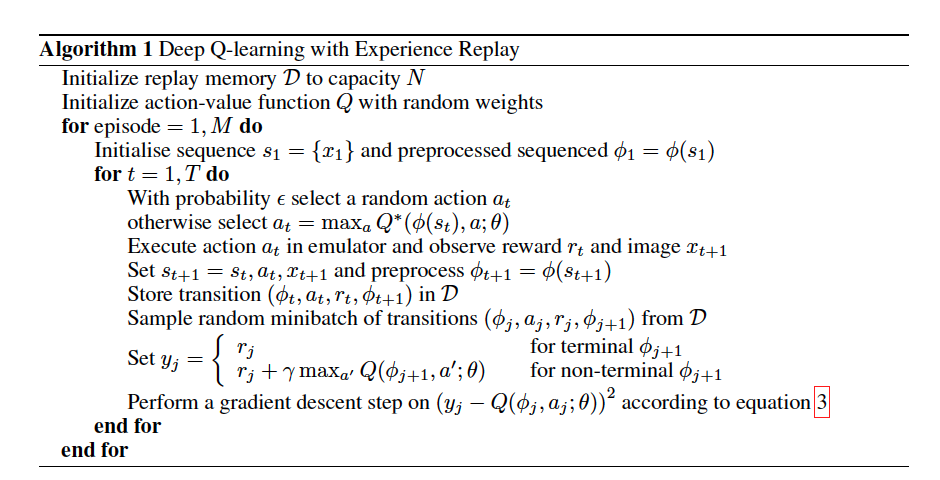

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from utils import *
from collections import namedtuple

import torch as tr
import gym

%load_ext autoreload
%autoreload 2

In [2]:
# setup
def experiment(nseeds,neps,kwargs):
  """
  interactrion logic
  a < agent(s,h)
  s',r  < env (a)
  
  """
  metric = np.zeros((ns,neps))
  # loop over seeds
  for s in range(ns):
    np.random.seed(s)
    tr.manual_seed(s)
    # setup
    agent = DQN()
    task = Task(max_ep_len=kwargs['max_ep_len'])
    buffer = Buffer(kwargs['buff_mode'],kwargs['buff_size'])
    for e in range(neps):
        ## score on greedy policy
        episode = task.play_ep(agent.argmax_policy_fn(1.0))
        metric[s,e] = np.sum(unpack_expL(episode)['reward'])
        ## train on softmax
        episode = task.play_ep(agent.argmax_policy_fn(0.85))
        buffer.record(episode)
        expLoD = buffer.sample(kwargs['batch_size'])
        # update
        exp = unpack_expL(expLoD)
        agent.train(exp)
  return metric



In [3]:
# run experiments
ns,ni=20,1000
kwargs = {'buff_size':500,'batch_size':128,'max_ep_len':100}
# sample from recent episodes
kwargs['buff_mode']='episodic'
m_episodic = experiment(ns,ni,kwargs)
# sample from distant past
kwargs['buff_mode']='online'
m_online = experiment(ns,ni,kwargs)

### visualize sum of episode rewards

In [4]:
def plt_metric(metric):
  # seeds and mean
  M = metric.mean(0)
  S = metric.std(0)/np.sqrt(ns)
  ax = plt.gca()
  ax.plot(M,zorder=99)
  for smet in metric:
    ax.plot(smet,c='k',lw=.01)

(-10.0, 100.0)

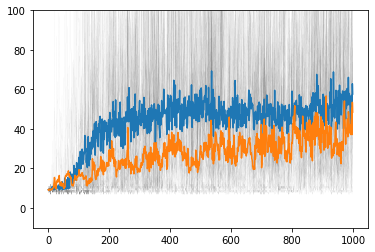

In [5]:
for metric in [m_online,m_episodic]:
  plt_metric(metric)
ax = plt.gca()
ax.set_ylim(-10,kwargs['max_ep_len'])

In [6]:
metric.shape

(20, 1000)

In [7]:
metric

array([[  8.,   9.,   9., ...,  55.,  63.,  35.],
       [ 11.,  10.,   9., ...,  91., 100.,  97.],
       [  8.,   9.,   9., ...,  32.,  51.,  44.],
       ...,
       [  8.,   9.,   9., ...,   8.,   9.,  10.],
       [  8.,   9.,  10., ...,  35., 100.,  99.],
       [  8.,   9.,   9., ..., 100.,  62.,  72.]])

## notes
- missing epsilon decay 
- network architecture and optimization params were not systematically adjusted

#### resources
- [mnih et al., 2015](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
- [torch DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
- [blog post](https://towardsdatascience.com/deep-q-learning-for-the-cartpole-44d761085c2f)